# Diamond EP Grouping by Resolution Limit - Feature Selection


Try to identify which features help model, and try to leave out uninformative features

In [1]:
import sys
import os
dirpath = r'C:\Users\César\PycharmProjects\Diamond_ML'
if dirpath not in sys.path:
    sys.path.insert(0, dirpath)
from read_data import data, pd, np, plt, plot_original_data
plt.style.use("ggplot")

Want to see which features are more important. Already have correlations table, but now fit optimised random forest and see which features are most important. The computations were done on a 1000 iteration RandomisedSearch on the DLS computer cluster.

DIALS


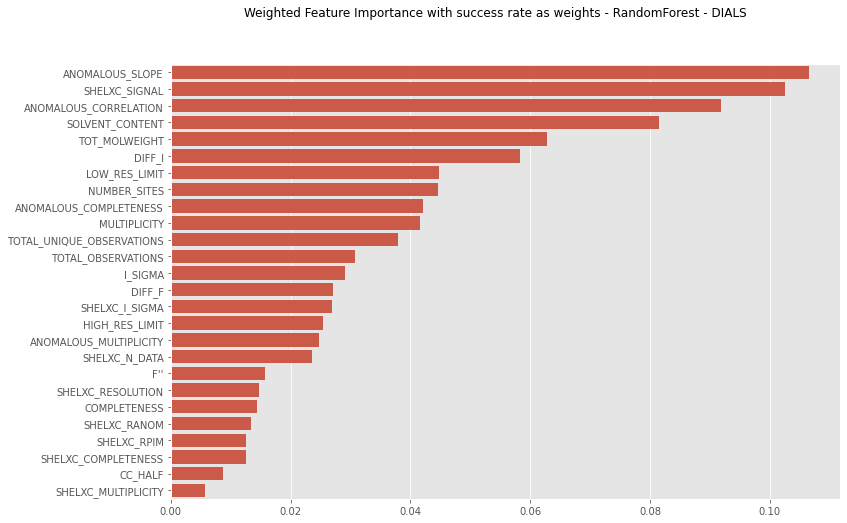

------------------------------------------------------------
3DII


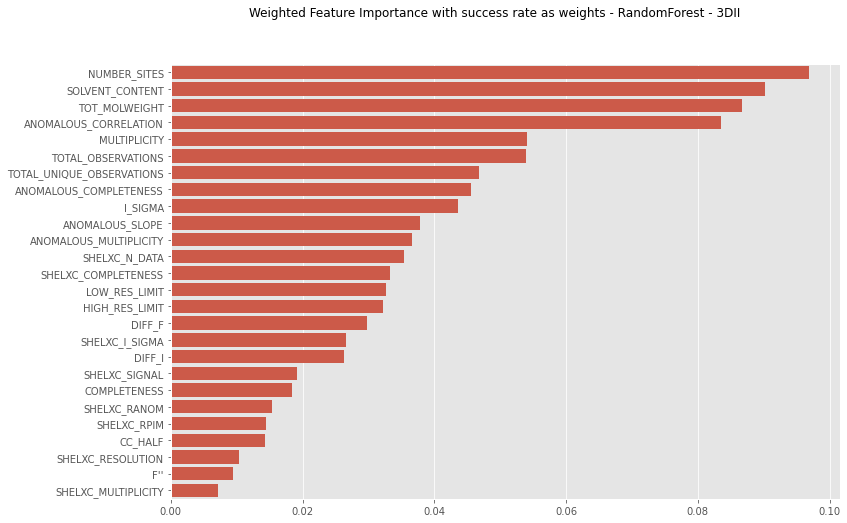

------------------------------------------------------------


In [73]:
import seaborn as sns


for db_kind in ["dials", "3dii"]:
    print(db_kind.upper())
    topfeats, weights,  = [], []
    
    # loop through every dataset
    for i in np.arange(1, 101):
        db_dir = fr"D:\Diamond\analysis\results\dataset_{i}\{db_kind}"
        
        # try to get feature importance csv data
        try:
            topfeat = pd.read_csv(os.path.join(db_dir, "topfeat.csv"), squeeze=True, index_col=0)
            cols = topfeat.index
            topfeats.append(topfeat.values.tolist())
            
            # get target for success rate to be used as weight
            y = data[db_kind].y
            success_rate = y.sum() / y.size
            weights.append(success_rate)
            
        # default to 0 if not found
        except FileNotFoundError:
            topfeats.append([0 for i in range(len(cols))])
            weights.append(0)

    
    # organise and sort top features
    topfeats = np.array(topfeats)
    topfeats_avg = np.average(topfeats, weights=weights, axis=0)
    topfeats_avg = pd.Series(topfeats_avg, index=cols).sort_values(ascending=False)
    
    # create figure
    plt.figure(figsize=(12, 8))
    plt.suptitle(f"Weighted Feature Importance with success rate as weights - RandomForest - {db_kind.upper()}")
    sns.barplot(x=topfeats_avg.values, y=topfeats_avg.index, color="C0")
    plt.show()
    
    print("-"*60)

## Method 1: Individual Removal

Here we will attempt to both perform PCA on, and remove, individual (or groups of) features to see if the model performance varies.

If there is **no significant variation** then that indicates that the removed features are **irrelevant** to the model. If the performance **decreases** they are **important**, and if it **increases** they are **detrimental**.

DIALS
Removing features: ["F''"]
Normal
> F1 Score: 67.96% +- 3.48%
> MCC: 54.84% +- 4.97%
PCA
> F1 Score: 67.90% +- 3.75%
> MCC: 54.74% +- 4.98%
Remove
> F1 Score: 67.47% +- 3.05%
> MCC: 54.19% +- 3.98%


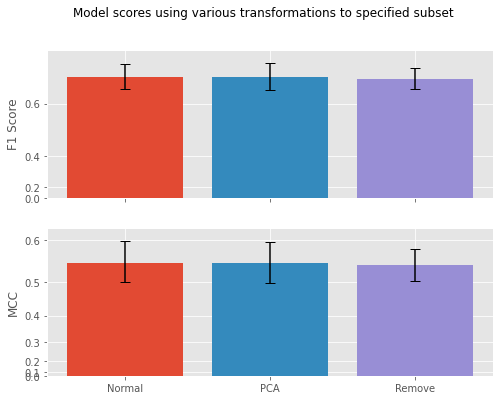

3DII
Removing features: ["F''"]
Normal
> F1 Score: 70.93% +- 0.63%
> MCC: 39.72% +- 1.60%
PCA
> F1 Score: 71.10% +- 0.40%
> MCC: 39.61% +- 0.98%
Remove
> F1 Score: 70.93% +- 0.50%
> MCC: 39.59% +- 1.53%


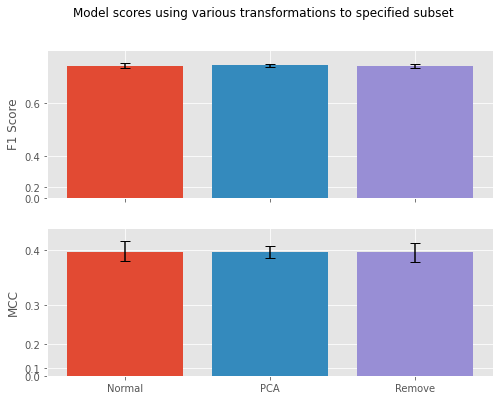

In [2]:
import seaborn as sns
from pca import pca as PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import matthews_corrcoef, f1_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint, uniform, sem
mcc = make_scorer(matthews_corrcoef)


def test_normal_pca_remove(estimator, X, y, feat2test, show=True, show_pca=False, random_state=None):
    # do PCA on two features
    pca = PCA(normalize=True, n_components=0.95)
    new = pca.fit_transform(X.loc[:, feat2test], verbose=2)
    if show_pca:
        pca.plot()

    # get new data subsets
    X_remove = X.drop(feat2test, axis=1)
    X_pca = X_remove.copy()
    X_pca = pd.concat([X_pca, new["PC"]], axis=1)
    
    # prepare figure
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
    
    for i, (x_part, name) in enumerate(zip([X, X_pca, X_remove], ["Normal", "PCA", "Remove"])):
        print(name)
        
        f1s = cross_val_score(forest, x_part, y, scoring='f1', cv=5, n_jobs=-1)
        mccs = cross_val_score(forest, x_part, y, scoring=mcc, cv=5, n_jobs=-1)
        f1_val, f1_err = f1s.mean(), sem(f1s)
        mcc_val, mcc_err = mccs.mean(), sem(mccs)
        
        ax1.bar(i, f1_val, yerr=f1_err, capsize=5)
        ax2.bar(i, mcc_val, yerr=mcc_err, capsize=5)
        
        print(f"> F1 Score: {f1_val:.2%} +- {f1_err:.2%}\n"
              f"> MCC: {mcc_val:.2%} +- {mcc_err:.2%}")
    
    # labels
    ax1.set_ylabel("F1 Score")
    ax2.set_ylabel("MCC")
    ax2.set_xticks([0, 1, 2])
    ax2.set_xticklabels(["Normal", "PCA", "Remove"])
    fig.suptitle(f"Model scores using various transformations to specified subset")
    
    if show:
        plt.show()
    return fig, (ax1, ax2)
    

seed = 2

for db_kind, datum in data.items():
    print(db_kind.upper())
    r_etc = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    x, y = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM", "SPACEGROUP"])
    
    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]
    x = x.drop(["DATASET_NAME"], axis=1)
    
    # get relevant features
    feats2test = ["F''"]
    print(f"Removing features: {feats2test}")
    x_part = x[feats2test]
    union_part = pd.concat([x_part, y], axis=1)
    
    # plot scatter plot
    #sns.lmplot(data=union_part, x="SHELXC_RPIM", y="SHELXC_RANOM", hue="IS_SUCCESS")
    #plt.show()
    
    # create model
    n_iter = 50
    forest = Pipeline([("scaler", StandardScaler()), ("clf", RandomForestClassifier(class_weight="balanced", random_state=seed))])
    forest_params = {"clf__criterion": ["gini", "entropy"],
                     "clf__n_estimators": randint(100, 10000),  # number of trees in forest
                     "clf__max_features": uniform(2/ len(x.columns), 1),  # max number of features when splitting
                     "clf__min_samples_split": randint(2, 20 + 1),  # min samples per node to induce split
                     "clf__max_depth": randint(5, 20 + 1),  # max number of splits to do
                     "clf__min_samples_leaf": randint(1, 10 + 1),  # min number of samples in a leaf; may set to 1 anyway
                     "clf__max_leaf_nodes": randint(10, 20 + 1)}  # max number of leaves}
    forest_search = RandomizedSearchCV(forest, forest_params, n_iter=n_iter, scoring="f1", n_jobs=-1, cv=5, random_state=seed)

    # test various features transforms
    fig, (ax1, ax2) = test_normal_pca_remove(forest_search, x, y, feats2test, show=False)
    ax1.set_yscale('function', functions=(lambda a: a**2, lambda a: a**.5))
    ax2.set_yscale('function', functions=(lambda a: a**2, lambda a: a**.5))
    
    plt.show()

Scores equivalent for all - no performance change. F'' is **irrelevant**.

Now test for RMERGE/RMEAS/RPIM (DIFF) I.

DIALS
Removing features: ['RMERGE_I', 'RMERGE_DIFF_I', 'RMEAS_I', 'RMEAS_DIFF_I', 'RPIM_I', 'RPIM_DIFF_I']


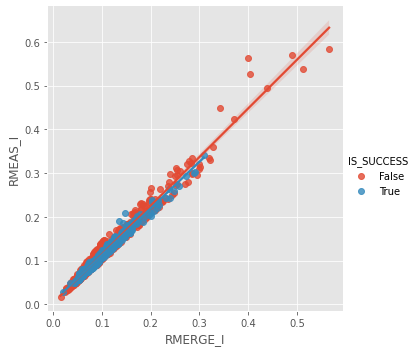

Normal
> F1 Score: 67.47% +- 3.05%
> MCC: 54.19% +- 3.98%
PCA
> F1 Score: 68.03% +- 3.68%
> MCC: 54.48% +- 5.01%
Remove
> F1 Score: 68.23% +- 4.03%
> MCC: 54.90% +- 5.55%


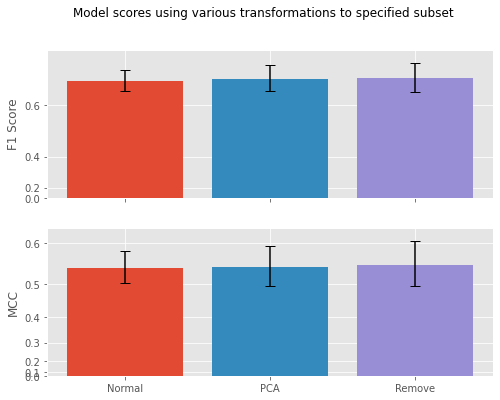

3DII
Removing features: ['RMERGE_I', 'RMERGE_DIFF_I', 'RMEAS_I', 'RMEAS_DIFF_I', 'RPIM_I', 'RPIM_DIFF_I']


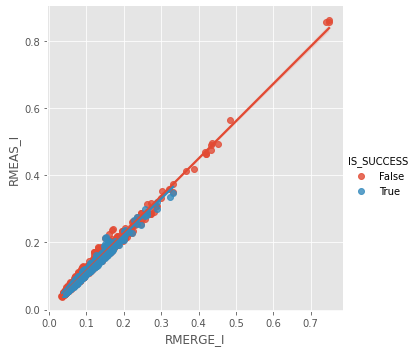

Normal
> F1 Score: 70.93% +- 0.50%
> MCC: 39.59% +- 1.53%
PCA
> F1 Score: 70.84% +- 0.53%
> MCC: 39.27% +- 1.37%
Remove
> F1 Score: 70.58% +- 0.94%
> MCC: 39.00% +- 1.13%


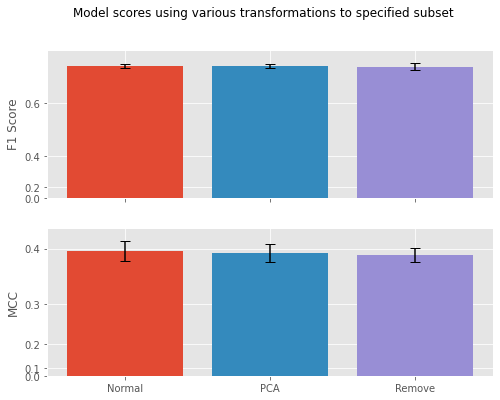

In [26]:
for db_kind, datum in data.items():
    print(db_kind.upper())
    r_etc = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    x, y = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM", "SPACEGROUP", "F''"])
    
    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]
    x = x.drop(["DATASET_NAME"], axis=1)
    
    # get relevant features
    feats2test = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    print(f"Removing features: {feats2test}")
    x_part = x[feats2test]
    union_part = pd.concat([x_part, y], axis=1)
    
    # plot scatter plot
    seed = 2
    sns.lmplot(data=union_part, x="RMERGE_I", y="RMEAS_I", hue="IS_SUCCESS")
    plt.show()
    
    # create model
    n_iter = 50
    forest = Pipeline([("scaler", StandardScaler()), ("clf", RandomForestClassifier(class_weight="balanced", random_state=seed))])
    forest_params = {"clf__criterion": ["gini", "entropy"],
                     "clf__n_estimators": randint(100, 10000),  # number of trees in forest
                     "clf__max_features": uniform(2/ len(x.columns), 1),  # max number of features when splitting
                     "clf__min_samples_split": randint(2, 20 + 1),  # min samples per node to induce split
                     "clf__max_depth": randint(5, 20 + 1),  # max number of splits to do
                     "clf__min_samples_leaf": randint(1, 10 + 1),  # min number of samples in a leaf; may set to 1 anyway
                     "clf__max_leaf_nodes": randint(10, 20 + 1)}  # max number of leaves}
    forest_search = RandomizedSearchCV(forest, forest_params, n_iter=n_iter, scoring="f1", n_jobs=-1, cv=5, random_state=seed)

    # test various features transforms
    fig, (ax1, ax2) = test_normal_pca_remove(forest_search, x, y, feats2test, show=False)
    ax1.set_yscale('function', functions=(lambda a: a**2, lambda a: a**.5))
    ax2.set_yscale('function', functions=(lambda a: a**2, lambda a: a**.5))
    
    plt.show()

A slight decrease in MCC can be seen, however this decrease disappears when the seed is varied. These feature also appear to be **irrelevant**.

Now test SHELXC_RPIM/RANOM

DIALS
Removing features: ['SHELXC_RANOM', 'SHELXC_RPIM']


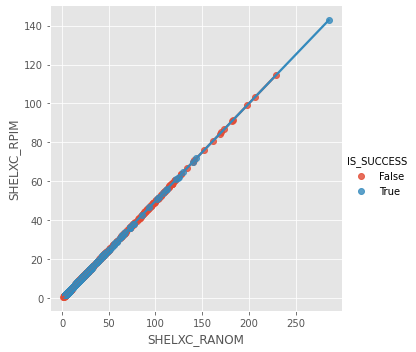

Normal
> F1 Score: 68.23% +- 4.03%
> MCC: 54.90% +- 5.55%
PCA
> F1 Score: 68.77% +- 3.49%
> MCC: 55.48% +- 5.07%
Remove
> F1 Score: 69.94% +- 3.32%
> MCC: 57.32% +- 4.97%


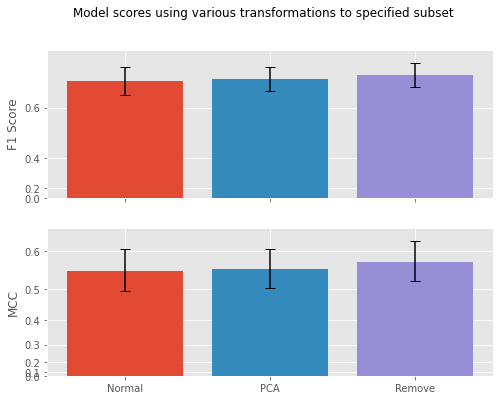

3DII
Removing features: ['SHELXC_RANOM', 'SHELXC_RPIM']


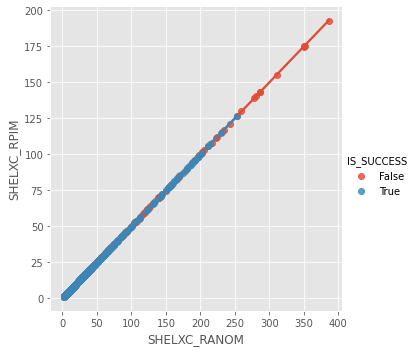

Normal
> F1 Score: 70.58% +- 0.94%
> MCC: 39.00% +- 1.13%
PCA
> F1 Score: 71.06% +- 0.97%
> MCC: 39.92% +- 1.85%
Remove
> F1 Score: 72.04% +- 0.76%
> MCC: 41.46% +- 1.47%


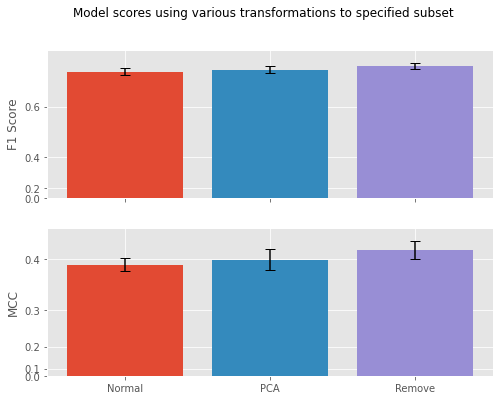

In [28]:
for db_kind, datum in data.items():
    print(db_kind.upper())
    r_etc = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    x, y = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM", "SPACEGROUP", "F''"] + r_etc)
    
    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]
    x = x.drop(["DATASET_NAME"], axis=1)
    
    # get relevant features
    feats2test = ["SHELXC_RANOM", "SHELXC_RPIM"]
    print(f"Removing features: {feats2test}")
    x_part = x[feats2test]
    union_part = pd.concat([x_part, y], axis=1)
    
    # plot scatter plot
    seed = 2
    sns.lmplot(data=union_part, x=feats2test[0], y=feats2test[1], hue="IS_SUCCESS")
    plt.show()
    
    # create model
    n_iter = 50
    forest = Pipeline([("scaler", StandardScaler()), ("clf", RandomForestClassifier(class_weight="balanced", random_state=seed))])
    forest_params = {"clf__criterion": ["gini", "entropy"],
                     "clf__n_estimators": randint(100, 10000),  # number of trees in forest
                     "clf__max_features": uniform(2/ len(x.columns), 1),  # max number of features when splitting
                     "clf__min_samples_split": randint(2, 20 + 1),  # min samples per node to induce split
                     "clf__max_depth": randint(5, 20 + 1),  # max number of splits to do
                     "clf__min_samples_leaf": randint(1, 10 + 1),  # min number of samples in a leaf; may set to 1 anyway
                     "clf__max_leaf_nodes": randint(10, 20 + 1)}  # max number of leaves}
    forest_search = RandomizedSearchCV(forest, forest_params, n_iter=n_iter, scoring="f1", n_jobs=-1, cv=5, random_state=seed)

    # test various features transforms
    fig, (ax1, ax2) = test_normal_pca_remove(forest_search, x, y, feats2test, show=False)
    ax1.set_yscale('function', functions=(lambda a: a**2, lambda a: a**.5))
    ax2.set_yscale('function', functions=(lambda a: a**2, lambda a: a**.5))
    
    plt.show()

This appears to be similar to before, which we determined to be irrelevant features to the model. We will also discard them, since they appear **irrelevant** or even **detrimental**.

Now try to remove features that we KNOW are relevant to the model. These vary between DIALS and XDS, but for DIALS we choose the **HR limit, SHELXC signal, Anomalous correlation/slope**.

DIALS
Removing features: ['HIGH_RES_LIMIT', 'SHELXC_SIGNAL', 'ANOMALOUS_CORRELATION', 'ANOMALOUS_SLOPE']


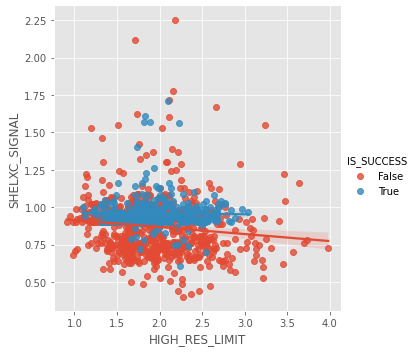

Normal
> F1 Score: 67.47% +- 3.05%
> MCC: 54.19% +- 3.98%
PCA
> F1 Score: 66.42% +- 3.30%
> MCC: 53.00% +- 4.50%
Remove
> F1 Score: 63.12% +- 2.78%
> MCC: 50.06% +- 3.66%


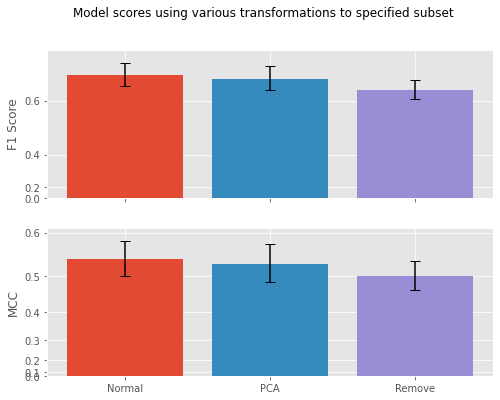

3DII
Removing features: ['HIGH_RES_LIMIT', 'SHELXC_SIGNAL', 'ANOMALOUS_CORRELATION', 'ANOMALOUS_SLOPE']


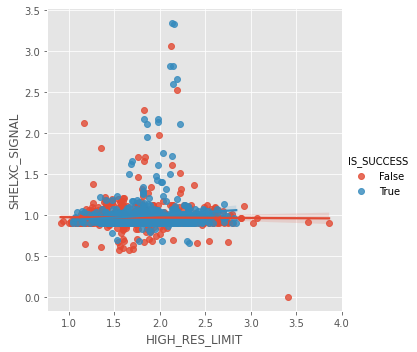

Normal
> F1 Score: 70.93% +- 0.50%
> MCC: 39.59% +- 1.53%
PCA
> F1 Score: 70.90% +- 0.82%
> MCC: 40.33% +- 1.65%
Remove
> F1 Score: 70.78% +- 0.58%
> MCC: 39.60% +- 1.79%


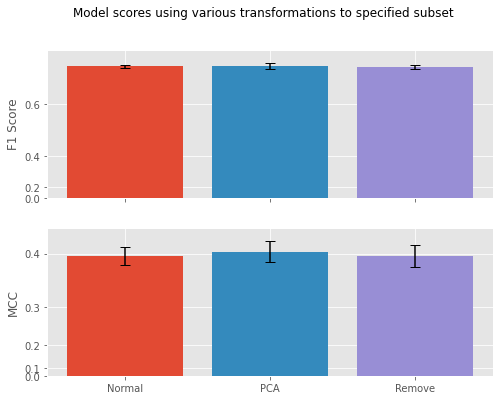

In [29]:
for db_kind, datum in data.items():
    print(db_kind.upper())
    r_etc = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    x, y = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM", "SPACEGROUP", "F''"])
    
    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]
    x = x.drop(["DATASET_NAME"], axis=1)
    
    # get relevant features
    feats2test = ["HIGH_RES_LIMIT", "SHELXC_SIGNAL", "ANOMALOUS_CORRELATION", "ANOMALOUS_SLOPE"]
    print(f"Removing features: {feats2test}")
    x_part = x[feats2test]
    union_part = pd.concat([x_part, y], axis=1)
    
    # plot scatter plot
    seed = 2
    sns.lmplot(data=union_part, x=feats2test[0], y=feats2test[1], hue="IS_SUCCESS")
    plt.show()
    
    # create model
    n_iter = 50
    forest = Pipeline([("scaler", StandardScaler()), ("clf", RandomForestClassifier(class_weight="balanced", random_state=seed))])
    forest_params = {"clf__criterion": ["gini", "entropy"],
                     "clf__n_estimators": randint(100, 10000),  # number of trees in forest
                     "clf__max_features": uniform(2/ len(x.columns), 1),  # max number of features when splitting
                     "clf__min_samples_split": randint(2, 20 + 1),  # min samples per node to induce split
                     "clf__max_depth": randint(5, 20 + 1),  # max number of splits to do
                     "clf__min_samples_leaf": randint(1, 10 + 1),  # min number of samples in a leaf; may set to 1 anyway
                     "clf__max_leaf_nodes": randint(10, 20 + 1)}  # max number of leaves}
    forest_search = RandomizedSearchCV(forest, forest_params, n_iter=n_iter, scoring="f1", n_jobs=-1, cv=5, random_state=seed)

    # test various features transforms
    fig, (ax1, ax2) = test_normal_pca_remove(forest_search, x, y, feats2test, show=False)
    ax1.set_yscale('function', functions=(lambda a: a**2, lambda a: a**.5))
    ax2.set_yscale('function', functions=(lambda a: a**2, lambda a: a**.5))
    
    plt.show()

As predicted, performance decreases for DIALS, but remains relatively constant for XDS, since the latter gives more importance to other features.

Note that the decrease in DIALS performance does not disappear by varying the seed. As such, these features are **important** for DIALS.


## Method 2: RFECV

Now try more complex feature selection methods.

First make use of the **R**ecursive **F**eature **E**limination **C**ross-**V**alidated model (RFECV). This model uses the feature_importances_ or coef_ properties of the classifier to determine the most/least important features and recursively remove the least important ones, giving a score to each feature subset.

The performance can then be plotted as a function of no. features, and the optimal features found.

The parameters chosen were the best parameters found using a 1000 iteration RandomizedSearch on the DLS cluster.

DIALS
Dropped 39.97% samples
(721, 34)
criterion            entropy
max_depth                 10
max_leaf_nodes            15
min_samples_leaf           1
min_samples_split          2
n_estimators             875
Name: 0, dtype: object
Testing removing features: Index(['F''', 'MULTIPLICITY', 'RMERGE_DIFF_I', 'RMEAS_DIFF_I', 'CC_HALF',
       'ANOMALOUS_MULTIPLICITY', 'SHELXC_MULTIPLICITY'],
      dtype='object')
Normal
> F1 Score: 76.20% +- 2.09%
> MCC: 64.11% +- 3.02%
PCA
> F1 Score: 77.87% +- 3.43%
> MCC: 66.16% +- 5.80%
Remove
> F1 Score: 78.38% +- 1.58%
> MCC: 66.36% +- 3.21%


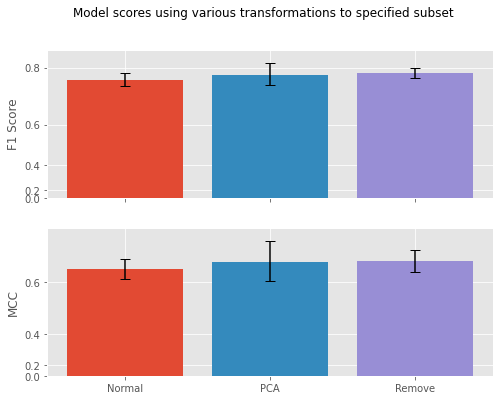

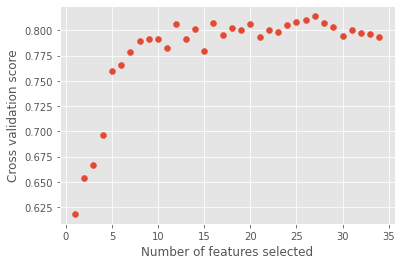

ANOMALOUS_SLOPE              1
TOT_MOLWEIGHT                1
NUMBER_SITES                 1
SOLVENT_CONTENT              1
SHELXC_SIGNAL                1
SHELXC_RANOM                 1
SHELXC_RPIM                  1
SHELXC_COMPLETENESS          1
SHELXC_I_SIGMA               1
SHELXC_N_DATA                1
SHELXC_RESOLUTION            1
TOTAL_UNIQUE_OBSERVATIONS    1
TOTAL_OBSERVATIONS           1
DIFF_I                       1
DIFF_F                       1
RESOLUTION_LOW               1
RESOLUTION_HIGH              1
ANOMALOUS_COMPLETENESS       1
HIGH_RES_LIMIT               1
RPIM_DIFF_I                  1
RPIM_I                       1
RMEAS_I                      1
ANOMALOUS_CORRELATION        1
RMERGE_I                     1
I_SIGMA                      1
COMPLETENESS                 1
LOW_RES_LIMIT                1
MULTIPLICITY                 2
RMERGE_DIFF_I                3
RMEAS_DIFF_I                 4
ANOMALOUS_MULTIPLICITY       5
F''                          6
CC_HALF 

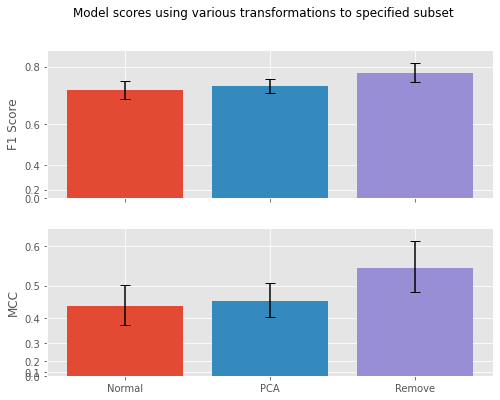

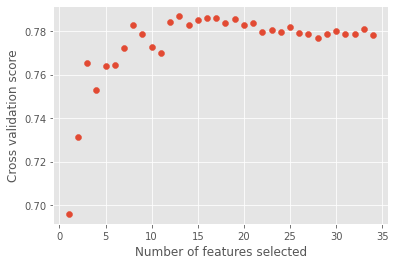

RESOLUTION_HIGH               1
HIGH_RES_LIMIT                1
TOT_MOLWEIGHT                 1
COMPLETENESS                  1
MULTIPLICITY                  1
NUMBER_SITES                  1
SHELXC_COMPLETENESS           1
SHELXC_N_DATA                 1
RMEAS_DIFF_I                  1
TOTAL_UNIQUE_OBSERVATIONS     1
ANOMALOUS_CORRELATION         1
ANOMALOUS_COMPLETENESS        1
ANOMALOUS_MULTIPLICITY        1
RMERGE_DIFF_I                 2
TOTAL_OBSERVATIONS            3
ANOMALOUS_SLOPE               4
RESOLUTION_LOW                5
I_SIGMA                       6
RPIM_DIFF_I                   7
SHELXC_RESOLUTION             8
DIFF_I                        9
SOLVENT_CONTENT              10
RMERGE_I                     11
LOW_RES_LIMIT                12
RPIM_I                       13
SHELXC_RANOM                 14
RMEAS_I                      15
SHELXC_I_SIGMA               16
DIFF_F                       17
SHELXC_RPIM                  18
CC_HALF                      19
SHELXC_S

In [3]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.neighbors import LocalOutlierFactor as LOF
from scipy.optimize import curve_fit


def exp_dec_inv(data, a, b):
    return b * (1 - np.exp(a * data))



for db_kind, datum in data.items():
    print(db_kind.upper())
    r_etc = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    x, y = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM", "SPACEGROUP"])
    
    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]
    x = x.drop(["DATASET_NAME"], axis=1)
    
    # remove outliers
    if db_kind == "dials":
        liers = LOF(contamination=0.4).fit_predict(x)
        mask = liers == 1
        print(f"Dropped {1-mask.sum()/mask.size:.2%} samples")
        x, y = x.loc[mask, :], y[mask]
    print(x.shape)
    
    # prepare best params
    db_dir = fr"D:\Diamond\analysis\results\dataset_{i}\{db_kind}\confidence_threshold"
    best_params = pd.read_csv(os.path.join(db_dir, "best_params_RandomForest.csv"), squeeze=True, index_col=0)
    best_params.index = best_params.index.str.replace("clf__", "")
    best_params.drop("max_features", inplace=True)  # bug with RFECV
    for ix, val in best_params.items():
        try:
            best_params[ix] = int(val)
        except ValueError:
            continue
    print(best_params)
    
    # create estimators
    seed = 1
    clf = RandomForestClassifier(random_state=seed, class_weight="balanced", **best_params)
    model = Pipeline([("scaler", StandardScaler()), ("clf", clf)])
        
    # separate into train/test datasets and train model
    X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=seed)
    
    # select best features
    selector = RFECV(model, n_jobs=4, cv=5, scoring="f1",
                     importance_getter="named_steps.clf.feature_importances_")
    selector.fit(X_train, y_train)
    feats2test = x.columns[~selector.support_]
    print("Testing removing features:", feats2test)
    
    # test performance removing bad features
    fig, (ax1, ax2) = test_normal_pca_remove(model, X_test, y_test, feats2test, show=False)
    ax1.set_yscale('function', functions=(lambda a: a**2, lambda a: a**.5))
    ax2.set_yscale('function', functions=(lambda a: a**2, lambda a: a**.5))
    
    
    # fit optimal curve to data
    hoz, ver = np.arange(1, len(selector.grid_scores_) + 1), selector.grid_scores_
    # popt, pcov = curve_fit(exp_dec_inv, hoz, ver, bounds=([0, 0], [2, 1]), p0=[0.7, 1])
    # print(popt)
    
    # plot results
    fig, ax = plt.subplots()
    ax.scatter(hoz, ver)
    ax.set_xlabel("Number of features selected")
    ax.set_ylabel("Cross validation score")
    
    # plot best fit curve
    # plt.plot(hoz, exp_dec_inv(hoz, *popt))
    plt.show()
    
    ranking = pd.Series(selector.ranking_, index=x.columns)
    print(ranking.sort_values())
    print(f"Optimal number of features: {sum(selector.support_)}")
    
    print("-"*60)

RFECV does manage to improve model performance. The importance given to each feature varies a bit, but there a few that agree with the feature importance graph previously found. This will be discussed after method 3.


## Method 3: Permutation Importance

This method first gets a **baseline** score, obtained by the normal sore on the regular dataset. The samples of each feature are then permutated and a score obtained. If the score is **similar** to the baseline, then that feature isn't important to model performance, it is **irrelevant**. Otherwise, if the score is lower, then that feature is **important** to the model.

The sklearn function automatically takes the difference between baseline and each feature's score to identify the most important one.

DIALS
Dropped 39.97% samples
(721, 34)
criterion            entropy
max_depth                 10
max_features              18
max_leaf_nodes            15
min_samples_leaf           1
min_samples_split          2
n_estimators             875
Name: 0, dtype: object


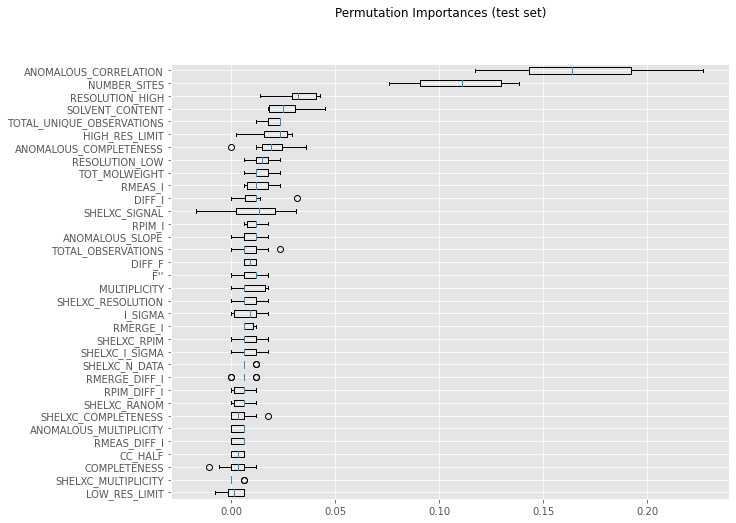

------------------------------------------------------------
3DII
(1450, 34)
criterion            entropy
max_depth                  7
max_features              21
max_leaf_nodes            20
min_samples_leaf           1
min_samples_split         11
n_estimators            7154
Name: 0, dtype: object


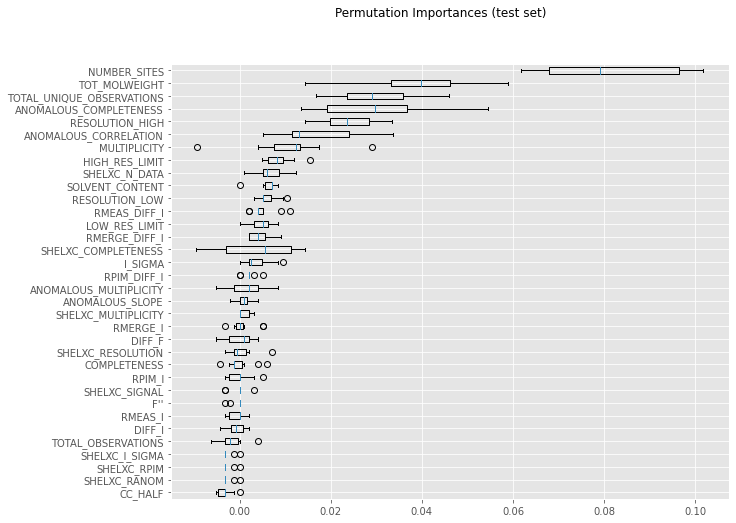

------------------------------------------------------------


In [7]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score, matthews_corrcoef
from sklearn.neighbors import LocalOutlierFactor as LOF


for db_kind, datum in data.items():
    print(db_kind.upper())
    r_etc = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    x, y = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM", "SPACEGROUP"])
    
    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]
    x = x.drop(["DATASET_NAME"], axis=1)
    
    # remove outliers
    if db_kind == "dials":
        liers = LOF(contamination=0.4).fit_predict(x)
        mask = liers == 1
        print(f"Dropped {1-mask.sum()/mask.size:.2%} samples")
        x, y = x.loc[mask, :], y[mask]
    print(x.shape)
    
    # prepare best params
    db_dir = fr"D:\Diamond\analysis\results\dataset_{i}\{db_kind}\confidence_threshold"
    best_params = pd.read_csv(os.path.join(db_dir, "best_params_RandomForest.csv"), squeeze=True, index_col=0)
    best_params.index = best_params.index.str.replace("clf__", "")
    for ix, val in best_params.items():
        try:
            best_params[ix] = int(val)
        except ValueError:
            continue
    print(best_params)
    best_params = best_params.to_dict()
    
    # create estimators
    seed = 1
    clf = RandomForestClassifier(random_state=seed, class_weight="balanced", **best_params)
    model = Pipeline([("scaler", StandardScaler()), ("clf", clf)])
    
    
    # separate into train/test datasets and train model
    X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=seed)
    
    # select best features
    model.fit(X_train, y_train)
    selector = permutation_importance(model, X_test, y_test, n_jobs=4,
                                      scoring="f1", n_repeats=10, random_state=seed)
    sorted_idx = selector.importances_mean.argsort()
    
    # plot results
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.boxplot(selector.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])
    fig.suptitle("Permutation Importances (test set)")
    plt.show()
    
    print("-"*60)

DIALS appears to value **anomalous correlation, number of sites, HR limit and solvent content** more than other features. While XDS values the **number of sites, total molecular weight, anomalous completeness and HR limit**, followed by a few others (including total unique observations, anomalous correlation, and LR limit).


## Method 4: Select KBest

Another method could be to only use the KBest features (e.g. 6 best features) in the model. This would improve model stability, since less variables are being considered.

DIALS
Dropped 39.97% samples
(721, 34)
criterion            entropy
max_depth                 10
max_leaf_nodes            15
min_samples_leaf           1
min_samples_split          2
n_estimators             875
Name: 0, dtype: object
--------------------
Best features for:
> f_classif
0              COMPLETENESS
1    ANOMALOUS_COMPLETENESS
2     ANOMALOUS_CORRELATION
3           ANOMALOUS_SLOPE
4                    DIFF_I
5             SHELXC_SIGNAL
6              NUMBER_SITES
dtype: object
> mutual_info_classif
0            LOW_RES_LIMIT
1    ANOMALOUS_CORRELATION
2                   DIFF_I
3          SOLVENT_CONTENT
4            TOT_MOLWEIGHT
5           RESOLUTION_LOW
6          RESOLUTION_HIGH
dtype: object


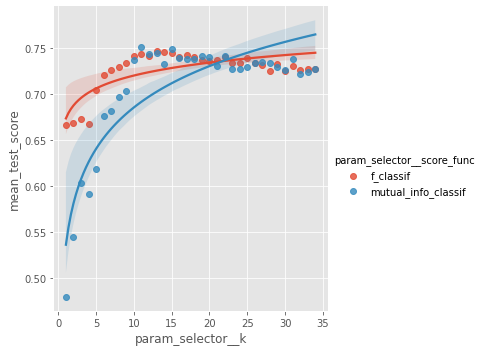

------------------------------------------------------------
3DII
(1450, 34)
criterion            entropy
max_depth                  7
max_leaf_nodes            20
min_samples_leaf           1
min_samples_split         11
n_estimators            7154
Name: 0, dtype: object
--------------------
Best features for:
> f_classif
0                 COMPLETENESS
1                 MULTIPLICITY
2       ANOMALOUS_COMPLETENESS
3        ANOMALOUS_CORRELATION
4    TOTAL_UNIQUE_OBSERVATIONS
5          SHELXC_COMPLETENESS
6                TOT_MOLWEIGHT
dtype: object
> mutual_info_classif
0             LOW_RES_LIMIT
1    ANOMALOUS_MULTIPLICITY
2           SOLVENT_CONTENT
3              NUMBER_SITES
4             TOT_MOLWEIGHT
5            RESOLUTION_LOW
6           RESOLUTION_HIGH
dtype: object


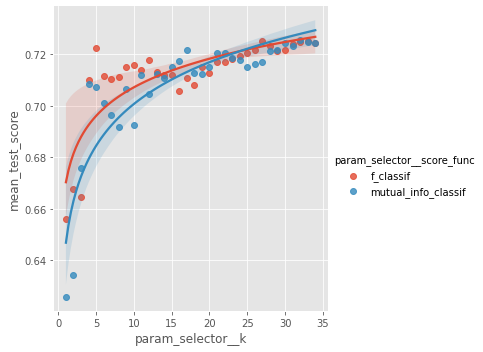

------------------------------------------------------------


In [15]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neighbors import LocalOutlierFactor as LOF

seed = 1


for db_kind, datum in data.items():
    print(db_kind.upper())
    r_etc = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    x, y = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM", "SPACEGROUP"])
    
    
    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]
    x = x.drop(["DATASET_NAME"], axis=1)
    
    # remove outliers
    if db_kind == "dials":
        liers = LOF(contamination=0.4).fit_predict(x)
        mask = liers == 1
        print(f"Dropped {1-mask.sum()/mask.size:.2%} samples")
        x, y = x.loc[mask, :], y[mask]
    print(x.shape)
    
    
    # prepare best params
    db_dir = fr"D:\Diamond\analysis\results\dataset_{i}\{db_kind}\confidence_threshold"
    best_params = pd.read_csv(os.path.join(db_dir, "best_params_RandomForest.csv"), squeeze=True, index_col=0)
    best_params.index = best_params.index.str.replace("clf__", "")
    best_params.drop("max_features", inplace=True)
    for ix, val in best_params.items():
        try:
            best_params[ix] = int(val)
        except ValueError:
            continue
    print(best_params)
    best_params = best_params.to_dict()
    
    # setup parameter grids
    param_grid = {"selector__k": np.arange(1, len(x.columns)+1),
                  "selector__score_func": [f_classif, mutual_info_classif]}
    
    
    # create estimators, pipeline and gridsearch
    seed = 1
    scaler = StandardScaler()
    selector = SelectKBest()
    clf = RandomForestClassifier(random_state=seed, class_weight="balanced", **best_params)
    pipe = Pipeline([("scaler", scaler), ("selector", selector), ("clf", clf)])
    search = GridSearchCV(pipe, param_grid, scoring="f1", n_jobs=4, cv=5)
        
    # train grid search and get best parameters
    # GridSearchCV uses cross-validation to train/test - fine to train on all data for accurate result
    search.fit(x, y)
    cv_results = pd.DataFrame(search.cv_results_)
    cv_results["param_selector__score_func"] = cv_results["param_selector__score_func"].map(lambda func: func.__name__)
    cv_results["param_selector__k"] = cv_results["param_selector__k"].astype(int)
    
    
    # show features chosen for k=7
    print("-"*20)
    print("Best features for:")
    for func in pd.unique(cv_results["param_selector__score_func"]):
        print(">", func)
        # get mask
        mask_func = cv_results["param_selector__score_func"] == func
        mask7 = cv_results["param_selector__k"] == 7
        mask = np.logical_and(mask_func, mask7)
        params7 = cv_results.loc[mask, "params"].iloc[0]
        
        # recreate pipeline
        pipe7 = Pipeline([("scaler", scaler), ("selector", selector), ("clf", clf)])
        pipe7.set_params(**params7)
        # fit and get support/features
        pipe7.fit(x, y)
        topfeats = x.columns[pipe7["selector"].get_support()].to_series(index=range(7))
        print(topfeats)
    
    # show results
    sns.lmplot(data=cv_results, x="param_selector__k", y="mean_test_score", hue="param_selector__score_func", logx=True)
    plt.show()
    
    print("-"*60)

DIALS performance increases up to ~12 features, from which point it decreases slightly. XDS, on the other hand, keeps increasing, even if only by a slight margin. This might indicate how XDS' features are each more important to sucess than DIALS, which prefers only a select few.

As such, the general conclusion for this method would be to take the **12 best features**, using either the f_classif or mutual_info_classif functions.


## Method 5: SelectPercentile

This method is similar to SelectKBest but instead of using a fixed number of features, it selects the features with a score above the selected percentile threshold.

DIALS
(1201, 34)
criterion            entropy
max_depth                 10
max_leaf_nodes            15
min_samples_leaf           1
min_samples_split          2
n_estimators             875
Name: 0, dtype: object


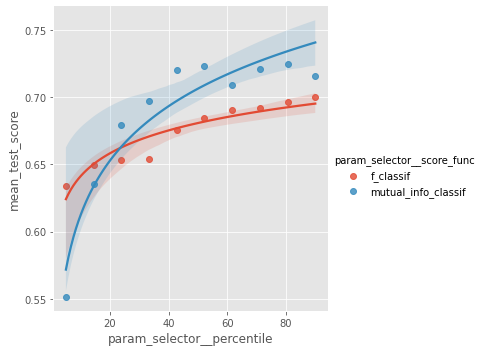

------------------------------------------------------------
3DII
(1450, 34)
criterion            entropy
max_depth                  7
max_leaf_nodes            20
min_samples_leaf           1
min_samples_split         11
n_estimators            7154
Name: 0, dtype: object


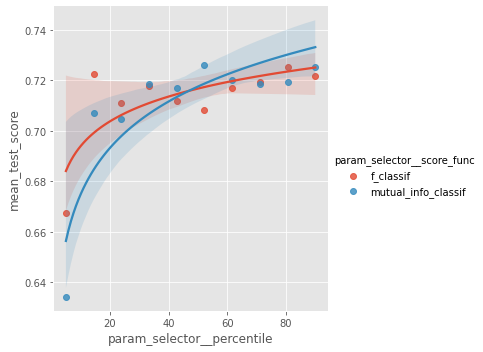

------------------------------------------------------------


In [30]:
from sklearn.feature_selection import SelectPercentile, chi2, f_classif, mutual_info_classif
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neighbors import LocalOutlierFactor as LOF

seed = 1


for db_kind, datum in data.items():
    print(db_kind.upper())
    r_etc = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    x, y = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM", "SPACEGROUP"])
    
    
    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]
    x = x.drop(["DATASET_NAME"], axis=1)
    
    # remove outliers
    '''if db_kind == "dials":
        liers = LOF(contamination=0.4).fit_predict(x)
        mask = liers == 1
        print(f"Dropped {1-mask.sum()/mask.size:.2%} samples")
        x, y = x.loc[mask, :], y[mask]'''
    print(x.shape)
    
    
    # prepare best params
    db_dir = fr"D:\Diamond\analysis\results\dataset_{i}\{db_kind}\confidence_threshold"
    best_params = pd.read_csv(os.path.join(db_dir, "best_params_RandomForest.csv"), squeeze=True, index_col=0)
    best_params.index = best_params.index.str.replace("clf__", "")
    best_params.drop("max_features", inplace=True)
    for ix, val in best_params.items():
        try:
            best_params[ix] = int(val)
        except ValueError:
            continue
    print(best_params)
    best_params = best_params.to_dict()
    
    # setup parameter grids
    param_grid = {"selector__percentile": np.linspace(5, 90, 10),
                  "selector__score_func": [f_classif, mutual_info_classif]}
    
    
    # create estimators, pipeline and gridsearch
    seed = 1
    scaler = StandardScaler()
    selector = SelectPercentile()
    clf = RandomForestClassifier(random_state=seed, class_weight="balanced", **best_params)
    pipe = Pipeline([("scaler", scaler), ("selector", selector), ("clf", clf)])
    search = GridSearchCV(pipe, param_grid, scoring="f1", n_jobs=4, cv=5)
        
    # train grid search and get best parameters
    # GridSearchCV uses cross-validation to train/test - fine to train on all data for accurate result
    search.fit(x, y)
    cv_results = pd.DataFrame(search.cv_results_)
    cv_results["param_selector__score_func"] = cv_results["param_selector__score_func"].map(lambda func: func.__name__)
    cv_results["param_selector__percentile"] = cv_results["param_selector__percentile"].astype(float)
    
    
    # show results
    sns.lmplot(data=cv_results, x="param_selector__percentile", y="mean_test_score", hue="param_selector__score_func", logx=True)
    #ax.set_yscale('function', functions=(lambda a: a**2, lambda a: a**.5))
    plt.show()
    
    print("-"*60)

The performance starts stabilising after ~40% percentile, similarly to the previous results. However, since the number of used features isn't clear, the previous methods ought to be used.

## Final Test

All this analysis gave us various results for feature importances. These vary slightly between the method used, and as such it can be hard to choose only a few features.

To make this clearer, we can store the top 7 features of each method in a dataframe, count the amount of times each features appear and tally them to get a final table of the most common top features.

In [8]:
# importances obtained previously in this notebook
topfeats_db_df = {"dials": {
    "forest": ["ANOMALOUS_SLOPE", "SHELXC_SIGNAL", "ANOMALOUS_CORRELATION", "SOLVENT_CONTENT", "TOT_MOLWEIGHT",
               "DIFF_I", "LOW_RES_LIMIT"],
    "permutation": ["ANOMALOUS_CORRELATION", "NUMBER_SITES", "RESOLUTION_HIGH", "SOLVENT_CONTENT", "TOTAL_UNIQUE_OBSERVATIONS",
                    "HIGH_RES_LIMIT", "ANOMALOUS_COMPLETENESS"],
    "kbest_f": ["COMPLETENESS", "ANOMALOUS_COMPLETENESS", "ANOMALOUS_CORRELATION", "ANOMALOUS_SLOPE", "DIFF_I",
                "SHELXC_SIGNAL", "NUMBER_SITES"],
    "kbest_mutual": ["LOW_RES_LIMIT", "ANOMALOUS_CORRELATION", "DIFF_I", "SOLVENT_CONTENT", "TOT_MOLWEIGHT",
                     "RESOLUTION_LOW", "RESOLUTION_HIGH"]
},
    "3dii": {
        "forest": ["NUMBER_SITES", "SOLVENT_CONTENT", "TOT_MOLWEIGHT", "ANOMALOUS_CORRELATION", "MULTIPLICITY",
                   "TOTAL_OBSERVATIONS", "TOTAL_UNIQUE_OBSERVATIONS"],
        "permutation": ["NUMBER_SITES", "TOT_MOLWEIGHT", "TOTAL_UNIQUE_OBSERVATIONS", "ANOMALOUS_COMPLETENESS",
                        "RESOLUTION_HIGH", "ANOMALOUS_CORRELATION", "MULTIPLICITY"],
        "kbest_f": ["COMPLETENESS", "MULTIPLICITY", "ANOMALOUS_COMPLETENESS", "ANOMALOUS_CORRELATION",
                    "TOTAL_UNIQUE_OBSERVATIONS", "SHELXC_COMPLETENESS", "TOT_MOLWEIGHT"],
        "kbest_mutual": ["LOW_RES_LIMIT", "ANOMALOUS_MULTIPLICITY", "SOLVENT_CONTENT", "NUMBER_SITES", "TOT_MOLWEIGHT",
                         "RESOLUTION_LOW", "RESOLUTION_HIGH"]
    }
}
bestfeats_db, medfeats_db = {}, {}


for db_kind, topfeats_dict in topfeats_db_df.items():
    print(db_kind.upper())
    target = 7

    # store in dataframe
    topfeats_df = pd.DataFrame(topfeats_dict)
    
    # get sorted value counts
    value_counts = np.unique(topfeats_df.values.flatten(), return_counts=True)
    value_counts = pd.Series(value_counts[1], value_counts[0]).sort_values(ascending=False)
    print(value_counts)
    print("-"*20)

    # show features with 3 or more counts
    bestfeats = value_counts.index[value_counts >= 3].values.astype(str)
    print(f"Set target of {target} features")
    print(f"Have {len(bestfeats)} best features (appeared 3 or more times):\n> {bestfeats}")


    # show options for those with 2 counts
    medfeats = value_counts.index[value_counts == 2].values.astype(str)
    print(f"{target-len(bestfeats)} features left to target, the {len(medfeats)} options are:\n> {medfeats}")
    
    # store values in dict
    bestfeats_db[db_kind] = bestfeats
    medfeats_db[db_kind] = medfeats

    print("-" * 60)

DIALS
ANOMALOUS_CORRELATION        4
DIFF_I                       3
SOLVENT_CONTENT              3
ANOMALOUS_COMPLETENESS       2
ANOMALOUS_SLOPE              2
LOW_RES_LIMIT                2
NUMBER_SITES                 2
RESOLUTION_HIGH              2
SHELXC_SIGNAL                2
TOT_MOLWEIGHT                2
COMPLETENESS                 1
HIGH_RES_LIMIT               1
RESOLUTION_LOW               1
TOTAL_UNIQUE_OBSERVATIONS    1
dtype: int64
--------------------
Set target of 7 features
Have 3 best features (appeared 3 or more times):
> ['ANOMALOUS_CORRELATION' 'DIFF_I' 'SOLVENT_CONTENT']
4 features left to target, the 7 options are:
> ['ANOMALOUS_COMPLETENESS' 'ANOMALOUS_SLOPE' 'LOW_RES_LIMIT' 'NUMBER_SITES'
 'RESOLUTION_HIGH' 'SHELXC_SIGNAL' 'TOT_MOLWEIGHT']
------------------------------------------------------------
3DII
TOT_MOLWEIGHT                4
ANOMALOUS_CORRELATION        3
MULTIPLICITY                 3
NUMBER_SITES                 3
TOTAL_UNIQUE_OBSERVATIONS    3
A

A few features appeared to be significantly important, appearing 3 or more times. These are:

- **DIALS**: Anomalous correlation, DIFF I, Solvent Content
- **XDS**: Tot Molweight, Anomalous correlation, Multiplicity, Number Sites

These ought to always be included in the analysis. As such we already have 3 essential features for DIALS, and 5 for XDS.

From my previous analysis, the features **Anomalous Slope** and **SHELXC Signal**, which both appear 2 times, are important to DIALS predictions. As such, I will include these in the list of *essential* features, bringing us to 5 features in each.

We can then try to choose +1 or 2 features (up  to 7), and see the best possible performance for each of this. This will indicate to us if we should include any other features.

DIALS
criterion            entropy
max_depth                 10
max_leaf_nodes            15
min_samples_leaf           1
min_samples_split          2
n_estimators             875
Name: 0, dtype: object
Dropped 39.97% samples
> Essential: ['ANOMALOUS_CORRELATION', 'DIFF_I', 'SOLVENT_CONTENT', 'ANOMALOUS_SLOPE', 'SHELXC_SIGNAL']
> Options: ['ANOMALOUS_COMPLETENESS', 'LOW_RES_LIMIT', 'NUMBER_SITES', 'RESOLUTION_HIGH', 'TOT_MOLWEIGHT']
RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_leaf_nodes=15, n_estimators=875,
                       random_state=1)
> Trying 0 extra features...
0 ['ANOMALOUS_CORRELATION', 'DIFF_I', 'SOLVENT_CONTENT', 'ANOMALOUS_SLOPE', 'SHELXC_SIGNAL'] 0.6969378778701614
> Trying 1 extra features...
3 ['ANOMALOUS_CORRELATION', 'DIFF_I', 'SOLVENT_CONTENT', 'ANOMALOUS_SLOPE', 'SHELXC_SIGNAL', 'RESOLUTION_HIGH'] 0.7295086025770804
> Trying 2 extra features...
7 ['ANOMALOUS_CORRELATION', 'DIFF_I', 'SOLVENT_CONT

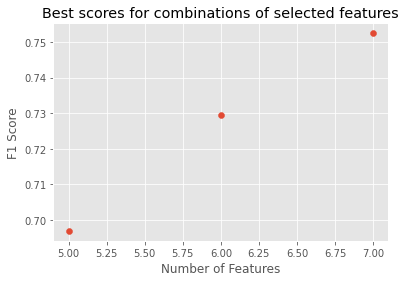

------------------------------------------------------------
3DII
criterion            entropy
max_depth                  7
max_leaf_nodes            20
min_samples_leaf           1
min_samples_split         11
n_estimators            7154
Name: 0, dtype: object
> Essential: ['TOT_MOLWEIGHT', 'ANOMALOUS_CORRELATION', 'MULTIPLICITY', 'NUMBER_SITES', 'TOTAL_UNIQUE_OBSERVATIONS']
> Options: ['ANOMALOUS_COMPLETENESS', 'RESOLUTION_HIGH', 'SOLVENT_CONTENT']
RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=7, max_leaf_nodes=20, min_samples_split=11,
                       n_estimators=7154, random_state=1)
> Trying 0 extra features...
0 ['TOT_MOLWEIGHT', 'ANOMALOUS_CORRELATION', 'MULTIPLICITY', 'NUMBER_SITES', 'TOTAL_UNIQUE_OBSERVATIONS'] 0.7340764627273981
> Trying 1 extra features...
0 ['TOT_MOLWEIGHT', 'ANOMALOUS_CORRELATION', 'MULTIPLICITY', 'NUMBER_SITES', 'TOTAL_UNIQUE_OBSERVATIONS', 'ANOMALOUS_COMPLETENESS'] 0.7297672909934312
> Tryi

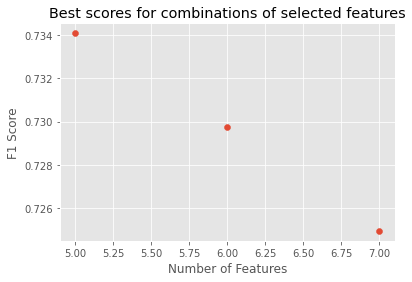

------------------------------------------------------------


In [10]:
from itertools import combinations
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier



for db_kind, datum in data.items():
    print(db_kind.upper())
    bestfeats, medfeats = list(bestfeats_db[db_kind]), list(medfeats_db[db_kind])
    x, y = datum.unpack(drop_col=["SPACEGROUP"])
    
    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]
    x = x.drop(["DATASET_NAME"], axis=1)
    
    # prepare best params
    db_dir = fr"D:\Diamond\analysis\results\dataset_{i}\{db_kind}\confidence_threshold"
    best_params = pd.read_csv(os.path.join(db_dir, "best_params_RandomForest.csv"), squeeze=True, index_col=0)
    best_params.index = best_params.index.str.replace("clf__", "")
    best_params.drop("max_features", inplace=True)
    for ix, val in best_params.items():
        try:
            best_params[ix] = int(val)
        except ValueError:
            continue
    print(best_params)
    best_params = best_params.to_dict()

    
    
    if db_kind == "dials":
        # change DIALS essential features
        to_change = ["ANOMALOUS_SLOPE", "SHELXC_SIGNAL"]
        bestfeats = list(bestfeats) + to_change
        medfeats = list(medfeats)
        for feat in to_change: medfeats.remove(feat)
            
        # remove outliers
        liers = LOF(contamination=0.4).fit_predict(x)
        mask = liers == 1
        print(f"Dropped {1-mask.sum()/mask.size:.2%} samples")
        x, y = x.loc[mask, :], y[mask]
    
    print("> Essential:", bestfeats)
    print("> Options:", medfeats)
    
    # create predictors
    clf = RandomForestClassifier(random_state=seed, class_weight="balanced", **best_params)
    pipe = Pipeline([("scaler", StandardScaler()), ("clf", clf)])
    print(clf)
    
    
    # iterate over i extra features
    topfeats = []
    topscores = []
    for i in range(target-len(bestfeats)+1):
        print(f"> Trying {i} extra features...")
        # get all feature combinations
        feats_comb = [bestfeats + list(comb) for comb in combinations(medfeats, i)]
        
        # get scores for all combinations and select best
        scores = [cross_val_score(pipe, x.loc[:, comb], y, cv=5, scoring="f1", n_jobs=4).mean() for comb in feats_comb]
        max_ix = np.argmax(scores)
        max_score, max_feats = scores[max_ix], feats_comb[max_ix]
        print(max_ix, max_feats, max_score)
        
        # store results
        topfeats.append(max_feats)
        topscores.append(max_score)
        
    
    # plot results
    plt.scatter([len(feats) for feats in topfeats], topscores)
    plt.xlabel("Number of Features")
    plt.ylabel("F1 Score")
    plt.title("Best scores for combinations of selected features")
    
    plt.show()
    print("-"*60)

DIALS performance increases by ~5% from 5 to 7 features, while XDS decreases by ~0.8% in the same range. As such, DIALS increases perforamnce, while XDS remains the same.

Aditionally, I've empirically seen how the high resolution limit appears to have significant impacts on resolution performance. As such, this feature ought to be included in all models.

In the sake of trying to minimise the number of features used, if given a maximum of 7 features, I would recommend using the following features:

- **DIALS**: **7** features - Anomalous Correlation, DIFF I, Solvent Content, Anomalous Slope, SHELXC Signal, Number Sites, Resolution High (or High res limit)
- **XDS**: **6** features - Tot Molweight, Anomalous Correlation, Multiplicity, Number Sites, Total Unique Observations, High res limit